In [28]:
import os
import snirf
import datetime
import numpy as np
import pandas as pd

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import firwin, lfilter
from typing import Union
from statistics import mean
from behav_analysis import Participant_Behav
from data_functions import Data_Functions, load_results


class Process_Flow:
    """
    This class contains functions for processing Kernel Flow data.
    Wrapper around an snirf.Snirf object.
    """

    def __init__(self, filepath: str) -> None:
        """
        Initialize by loading SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.
        """
        self.data_fun = Data_Functions()
        self.snirf_file = self.load_snirf(filepath)

    def load_snirf(self, filepath: str) -> snirf.Snirf:
        """
        Load SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.

        Returns:
            snirf.Snirf: SNIRF file object.
        """
        return snirf.Snirf(filepath, "r+", dynamic_loading=True)

    def get_time_origin(
        self, fmt: str = "datetime", offset=True
    ) -> Union[datetime.datetime, float]:
        """
        Get the time origin (start time) from the SNIRF file.

        Args:
            fmt (str, optional): Format to get the time origin in: "datetime" or "timestamp". Defaults to "datetime".
            offset (bool): Offset the datetime by 4 hours. Defaults to True.

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            Union[datetime.datetime, float]:
                datetime.datetime: Time origin datetime.
                -or-
                float: Time origin timestamp.
        """
        start_date = self.snirf_file.nirs[0].metaDataTags.MeasurementDate
        start_time = self.snirf_file.nirs[0].metaDataTags.MeasurementTime
        start_str = start_date + " " + start_time
        if offset:
            time_origin = datetime.datetime.strptime(
                start_str, "%Y-%m-%d %H:%M:%S"
            ) - datetime.timedelta(
                hours=4
            )  # 4 hour offset
        else:
            time_origin = datetime.datetime.strptime(start_str, "%Y-%m-%d %H:%M:%S")
        if fmt.lower() == "datetime":
            return time_origin
        elif fmt.lower() == "timestamp":
            return datetime.datetime.timestamp(time_origin)
        else:
            raise Exception(
                "Invalid 'fmt' argument. Must be 'datetime' or 'timestamp'."
            )

    def get_subject_ID(self) -> str:
        """
        Get the subject ID from the SNIRF file.

        Returns:
            str: Subject ID.
        """
        return self.snirf_file.nirs[0].metaDataTags.SubjectID

    def get_time_rel(self) -> np.ndarray:
        """
        Get the relative time array from the SNIRF file.

        Returns:
            np.ndarray: Relative time array.
        """
        return self.snirf_file.nirs[0].data[0].time

    def get_time_abs(self, fmt: str = "datetime") -> np.ndarray:
        """
        Convert relative time array into an absolute time array.

        Args:
            fmt (str, optional): Format to get the time array in: "datetime" or "timestamp". Defaults to "datetime".

        Returns:
            np.ndarray: Absolute time array.
        """
        time_rel = self.get_time_rel()
        if fmt.lower() == "datetime":
            time_origin_dt = self.get_time_origin("datetime")
            return np.array(
                [
                    datetime.timedelta(seconds=time_rel[i]) + time_origin_dt
                    for i in range(len(time_rel))
                ]
            )
        elif fmt.lower() == "timestamp":
            time_origin_ts = self.get_time_origin("timestamp")
            return time_rel + time_origin_ts

    def get_data(
        self, fmt: str = "array", cols: list[int | list | tuple] = None
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Get timeseries data from the SNIRF file.

        Args:
            fmt (str): Format of data (np.ndarray or pd.DataFrame). Defaults to "array".
            cols (list[int | list | tuple]): Data cols to select. Single col, list of cols, or slice of cols.
                                             Defaults to None (all columns).

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            np.ndarray: Timeseries data array.
        """
        if cols or cols == 0:
            if isinstance(cols, tuple):
                data = (
                    self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols[0] : cols[1]]
                )
            else:
                data = self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols]
        else:
            data = self.snirf_file.nirs[0].data[0].dataTimeSeries

        if "array" in fmt.lower():
            return data
        elif "dataframe" in fmt.lower():
            return pd.DataFrame(data)
        else:
            raise Exception("Invalid fmt argument. Must be 'array' or 'dataframe'.")

    def get_source_pos_2d(self) -> np.ndarray:
        """
        Get the 2D source position array.

        Returns:
            np.ndarray: 2D source position array
        """
        return self.snirf_file.nirs[0].probe.sourcePos2D

    def get_source_pos_3d(self) -> np.ndarray:
        """
        Get the 3D source position array.

        Returns:
            np.ndarray: 3D source position array
        """
        return self.snirf_file.nirs[0].probe.sourcePos3D

    def get_detector_pos_2d(self) -> np.ndarray:
        """
        Get the 2D detector position array.

        Returns:
            np.ndarray: 2D detector position array
        """
        return self.snirf_file.nirs[0].probe.detectorPos2D

    def get_detector_pos_3d(self) -> np.ndarray:
        """
        Get the 3D detector position array.

        Returns:
            np.ndarray: 3D detector position array
        """
        return self.snirf_file.nirs[0].probe.detectorPos3D
    
    def get_measurement_list(self) -> np.array:
        """
        Get the data measurement list.

        Returns:
            np.array: Data measurement list.
        """
        return self.snirf_file.nirs[0].data[0].measurementList

    def get_marker_df(self) -> pd.DataFrame:
        """
        Get a DataFrame of marker data from the "stim" part of the SNIRF file.

        Returns:
            pd.DataFrame: Marker "stim" data.
        """
        marker_data = self.snirf_file.nirs[0].stim[0].data
        marker_data_cols = self.snirf_file.nirs[0].stim[0].dataLabels
        return pd.DataFrame(marker_data, columns=marker_data_cols)

    def get_unique_data_types(self) -> list:
        """
        Get unique data types from the SNIRF file.

        Returns:
            list: Unique data types.
        """
        data_types = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type = self.snirf_file.nirs[0].data[0].measurementList[i].dataType
            if data_type not in data_types:
                data_types.append(data_type)
        return data_types

    def get_data_type_label(self, channel_num: int) -> str:
        """
        Get the data type label for a channel(s).

        Args:
            channel_num (int): Channel number to get the data type label of.

        Returns:
            str: Data type label of the channel.
        """
        return (
            self.snirf_file.nirs[0].data[0].measurementList[channel_num].dataTypeLabel
        )

    def get_unique_data_type_labels(self) -> list:
        """
        Get unique data type labels from the SNIRF file.

        Returns:
            list: Unique data type labels.
        """
        data_type_labels = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type_label = (
                self.snirf_file.nirs[0].data[0].measurementList[i].dataTypeLabel
            )
            if data_type_label not in data_type_labels:
                data_type_labels.append(data_type_label)
        return data_type_labels

    def create_source_dict(self) -> dict:
        """
        Count the occurrences of each source index.

        Returns:
            dict: Counts for each source index.
        """
        source_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            source = self.snirf_file.nirs[0].data[0].measurementList[i].sourceIndex
            source_dict[source] = source_dict.get(source, 0) + 1
        source_dict = self.data_fun.sort_dict(source_dict, "keys")
        return source_dict

    def create_detector_dict(self) -> dict:
        """
        Count the occurrences of each detector index.

        Returns:
            dict: Counts for each detector index.
        """
        detector_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            detector = self.snirf_file.nirs[0].data[0].measurementList[i].detectorIndex
            detector_dict[detector] = detector_dict.get(detector, 0) + 1
        detector_dict = self.data_fun.sort_dict(detector_dict, "keys")
        return detector_dict
    
    def create_measurement_list_df(self) -> pd.DataFrame:
        """
        Create a DataFrame with all the data measurement list information.

        
        Returns:
            pd.DataFrame: Data measurement list DataFrame.
        """
        measurement_list = self.get_measurement_list()
        dict_list = []

        for i in range(len(measurement_list)):
            measurement_list_i = measurement_list[i]
            measurement_dict = {}
            measurement_dict["measurement_list_index"] = i+1 
            measurement_dict["data_type"] = measurement_list_i.dataType
            measurement_dict["data_type_index"] = measurement_list_i.dataTypeLabel
            measurement_dict["detector_index"] = measurement_list_i.detectorIndex
            measurement_dict["source_index"] = measurement_list_i.sourceIndex
            dict_list.append(measurement_dict)

        measurement_list_df = pd.DataFrame(dict_list)
        return measurement_list_df

    def plot_pos_2d(self) -> None:
        """
        Plot the detector/source 2D positions.
        """
        detector_pos_2d = self.get_detector_pos_2d()
        x_detector = detector_pos_2d[:, 0]
        y_detector = detector_pos_2d[:, 1]

        source_pos_2d = self.get_source_pos_2d()
        x_source = source_pos_2d[:, 0]
        y_source = source_pos_2d[:, 1]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(x_detector, y_detector)
        ax.scatter(x_source, y_source)
        ax.set_title("Detector/Source 2D Plot")
        ax.set_xlabel("X-Position (mm)")
        ax.set_ylabel("Y-Position (mm)")
        ax.legend(["Detector", "Source"])

    def plot_pos_3d(self) -> None:
        """
        Plot the detector/source 3D positions.
        """
        detector_pos_3d = self.get_detector_pos_3d()
        x_detector = detector_pos_3d[:, 0]
        y_detector = detector_pos_3d[:, 1]
        z_detector = detector_pos_3d[:, 2]

        source_pos_3d = self.get_source_pos_3d()
        x_source = source_pos_3d[:, 0]
        y_source = source_pos_3d[:, 1]
        z_source = source_pos_3d[:, 2]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(x_detector, y_detector, z_detector)
        ax.scatter(x_source, y_source, z_source)
        ax.set_title("Detector/Source 3D Plot")
        ax.set_xlabel("X-Position (mm)")
        ax.set_ylabel("Y-Position (mm)")
        ax.set_zlabel("Z-Position (mm)")
        ax.legend(["Detector", "Source"])


class Participant_Flow:
    """
    This class contains functions, data structures, and info necessary for
    processing Kernel Flow data from the experiments.
    """

    def __init__(self, par_num):
        self.data_fun = Data_Functions()
        self.adj_ts_markers = True
        self.par_behav = Participant_Behav(par_num, self.adj_ts_markers)
        self.par_num, self.par_ID = self.data_fun.process_par(par_num)
        self.flow_raw_data_dir = os.path.join(
            self.par_behav.raw_data_dir, self.par_ID, "kernel_data"
        )
        self.flow_processed_data_dir = os.path.join(
            os.getcwd(), "processed_data", "flow"
        )
        self.flow_session_dict = self.create_flow_session_dict(wrapper=True)
        self.time_offset_dict = self.create_time_offset_dict()
        self.plot_color_dict = {
            0: "purple",
            1: "orange",
            2: "green",
            3: "yellow",
            4: "pink",
            5: "skyblue",
        }

    def calc_time_offset(self, exp_name: str) -> float:
        """
        Calculate the time offset (in seconds) between the behavioral and Kernel Flow data
        files. Number of seconds that the Kernel Flow data is ahead of the behavioral data.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            float: Time offset (in seconds).
        """
        exp = self.par_behav.get_exp(exp_name)
        exp_start_ts = exp.start_ts
        marker_sent_time = float(exp.marker_data["start_marker"]["sent_time"])
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        marker_df = self.create_abs_marker_df(session)
        row = marker_df.loc[marker_df["Marker"].str.startswith(exp_name)].reset_index()
        if (
            exp_name == "go_no_go"
        ):  # Go/No-go experiment is missing start timestamp marker
            try:
                kernel_start_ts = row.loc[0, "Start timestamp"]
                time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
            except:
                time_offset = "NaN"
        else:
            kernel_start_ts = row.loc[0, "Start timestamp"]
            time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
        return float(time_offset)

    def create_time_offset_dict(self) -> dict:
        """
        Create a dictionary containing the time offset (in seconds) for each experiment.

        Returns:
            dict: Time offset dictionary.
        """
        time_offset_dict = {}
        for exp_name in self.par_behav.exp_order:
            if (
                exp_name == "go_no_go"
            ):  # Go/No-go experiment is missing start timestamp marker
                if np.isnan(self.calc_time_offset(exp_name)):
                    session = self.par_behav.get_key_from_value(
                        self.par_behav.session_dict, exp_name
                    )
                    session_exp_names = self.par_behav.session_dict[session]
                    other_exp_names = [
                        temp_exp_name
                        for temp_exp_name in session_exp_names
                        if temp_exp_name != "go_no_go"
                    ]
                    other_exp_time_offsets = []
                    for temp_exp_name in other_exp_names:
                        time_offset = self.calc_time_offset(temp_exp_name)
                        other_exp_time_offsets.append(time_offset)
                    avg_time_offset = np.mean(other_exp_time_offsets)
                    time_offset_dict[exp_name] = avg_time_offset
            else:
                time_offset_dict[exp_name] = self.calc_time_offset(exp_name)
        for session, exp_list in self.par_behav.session_dict.items():
            session_offset = np.mean(
                [time_offset_dict[exp_name] for exp_name in exp_list]
            )
            time_offset_dict[session] = session_offset
        return time_offset_dict

    def get_time_offset(self, exp_name: str) -> float:
        """
        Get the time offset for an experiment.

        Args:
            exp_name (str): Experiment name.

        Returns:
            float: Time offset (in seconds).
        """
        return self.time_offset_dict[exp_name]

    def offset_time_array(self, exp_name: str, time_array: np.ndarray) -> np.ndarray:
        """
        Offset a Kernel Flow datetime array for an experiment by the time-offset.

        Args:
            exp_name (str): Name of the experiment.
            time_array (np.ndarray): Datetime array.

        Returns:
            np.ndarray: Time-offset datetime array.
        """
        try:
            time_offset = self.get_time_offset(exp_name)
        except KeyError:  # if experiment start time is missing, use avg of other session experiments
            time_offset_list = []
            for exp_name in self.par_behav.exp_order:
                try:
                    time_offset = self.get_time_offset(exp_name)
                    time_offset_list.append(time_offset)
                except KeyError:
                    pass
            time_offset = mean(time_offset_list)
        time_offset_dt = datetime.timedelta(seconds=time_offset)
        time_abs_dt_offset = time_array - time_offset_dt
        return time_abs_dt_offset

    def load_flow_session(
        self, session: list[str | int], wrapper: bool = False
    ) -> snirf.Snirf:
        """
        Load Kernel Flow data for an experiment session.

        Args:
            session list[str | int]: Experiment session.
            wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                     Defaults to false.

        Raises:
            Exception: Invalid session number argument.

        Returns:
            snirf.Snirf: SNIRF file object.
            -or-
            Process_Flow object for each experiment session.
        """
        if isinstance(session, str):
            if "session" not in session:
                session = f"session_{session}"
        elif isinstance(session, int):
            session = f"session_{session}"
        try:
            session_dir = os.path.join(self.flow_raw_data_dir, session)
            filename = os.listdir(session_dir)[0]
            filepath = os.path.join(session_dir, filename)
            if wrapper:
                return Process_Flow(filepath)
            else:
                return Process_Flow(filepath).snirf_file
        except:
            print("Invalid session number.")
            raise

    def load_flow_exp(self, exp_name: str) -> pd.DataFrame:
        """
        Load Kernel Flow data for the time frame of a specified experiment.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            pd.DataFrame: Kernel Flow data for an experiment.
        """
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        flow_session = self.load_flow_session(session, wrapper=True)

        start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = self.offset_time_array(exp_name, time_abs_dt)
        start_idx = self.par_behav.get_start_index_dt(time_abs_dt_offset, start_dt)
        end_idx = self.par_behav.get_end_index_dt(time_abs_dt_offset, end_dt)

        flow_data = flow_session.get_data("dataframe")
        flow_data.insert(0, "datetime", time_abs_dt_offset)
        return flow_data.iloc[start_idx:end_idx, :]

    def create_flow_session_dict(self, wrapper: bool = False) -> dict:
        """
        Create a dictionary of Kernel Flow data for all experiment sessions.

        wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                 Default to false.

        Returns:
            dict: Kernel Flow data for all experiment sessions.
                keys:
                    "session_1001", "session_1002", "session_1003"
                values:
                    SNIRF file object for each experiment session
                    -or-
                    Process_Flow object for each experiment session
        """
        flow_session_dict = {}
        for session in self.par_behav.session_dict.keys():
            flow_session_dict[session] = self.load_flow_session(session, wrapper)
        return flow_session_dict

    def create_abs_marker_df(self, session: str) -> pd.DataFrame:
        """
        Convert the "stim" marker DataFrame into absolute time.

        Args:
            session (str): Experiment session.

        Returns:
            pd.DataFrame: Marker "stim" data in absolute time.
        """
        marker_df = self.flow_session_dict[session].get_marker_df()
        time_origin_ts = self.flow_session_dict[session].get_time_origin("timestamp")
        marker_df["Timestamp"] = marker_df["Timestamp"] + time_origin_ts
        marker_df.rename({"Timestamp": "Start timestamp"}, axis=1, inplace=True)

        for idx, row in marker_df.iterrows():
            end_ts = row["Start timestamp"] + row["Duration"]
            marker_df.at[idx, "End timestamp"] = end_ts
            exp_num = int(row["Experiment"])
            exp_name = self.par_behav.marker_dict[exp_num]
            marker_df.at[idx, "Experiment"] = exp_name

        marker_df.rename({"Experiment": "Marker"}, axis=1, inplace=True)
        marker_df.drop(["Value"], axis=1, inplace=True)
        marker_df = marker_df[
            ["Marker", "Start timestamp", "Duration", "End timestamp"]
        ]
        return marker_df

    def create_exp_stim_response_dict(self, exp_name: str) -> dict:
        """
        Create a dictionary that contains the processed Kernel Flow data in response
        to a stimulus. It is organized by block (keys) and for each block, the value is
        a list of Pandas series.  Each series is normalized, averaged, Kernel Flow data
        during a presented stimulus duration for each channel.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            dict:
                keys:
                    "block 1", "block 2", ... "block N"
                values:
                    dicts:
                        keys:
                            "trial 1", "trial 2", ... "trial N"
                        values:
                            lists of averaged, normalized Kernel Flow data series for each
                            channel during the stimulus duration
        """
        exp_results = load_results(
            self.par_behav.processed_data_dir, exp_name, self.par_behav.par_num
        )
        flow_exp = self.load_flow_exp(exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        ts_list = self.flow_session_dict[session].get_time_abs("timestamp")
        exp_time_offset = self.time_offset_dict[exp_name]
        blocks = list(exp_results["block"].unique())
        exp_stim_resp_dict = {
            block: {} for block in blocks
        }  # initialize with unique blocks
        for _, row in exp_results.iterrows():
            stim_start_ts = row["stim_start"]
            stim_start_ts_offset = stim_start_ts + exp_time_offset
            start_idx, _ = self.data_fun.find_closest_ts(stim_start_ts_offset, ts_list)
            stim_end_ts = row["stim_end"]
            stim_end_ts_offset = stim_end_ts + exp_time_offset
            end_idx, _ = self.data_fun.find_closest_ts(stim_end_ts_offset, ts_list)

            baseline_row = flow_exp.loc[start_idx, 0:]
            stim_rows = flow_exp.loc[start_idx:end_idx, 0:]
            avg_norm_rows = (stim_rows - baseline_row).mean()  # all channels for a stim

            block = row["block"]
            trial = row["trial"]
            if trial not in exp_stim_resp_dict[block].keys():
                exp_stim_resp_dict[block][trial] = []
            exp_stim_resp_dict[block][trial].append(
                avg_norm_rows
            )  # add to a block in dict
        return exp_stim_resp_dict

    def create_exp_stim_response_df(self, exp_name: str) -> pd.DataFrame:
        """
        Create a DataFrame that contains the processed Kernel Flow data in response
        to each stimulus in an experiment. Each channel is normalized and averaged.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            pd.DataFrame: Processed Kernel Flow data.
        """

        def split_col(row: pd.Series) -> pd.Series:
            """
            Split a column containing an array into separate columns for each
            element in the array.

            Args:
                row (pd.Series): DataFrame row.

            Returns:
                pd.Series: DataFrame row with split column.
            """
            arr = row["Channels"]
            num_elements = len(arr)
            col_names = [i for i in range(num_elements)]
            return pd.Series(arr, index=col_names)

        exp_baseline_avg_dict = self.create_exp_stim_response_dict(exp_name)
        rows = []
        for block, block_data in sorted(exp_baseline_avg_dict.items()):
            for trial, stim_resp_data in block_data.items():
                trial_avg = np.mean(stim_resp_data, axis=0)
                row = {
                    "Participant": self.par_num,
                    "Block": block,
                    "Channels": trial_avg,
                }
                rows.append(row)

        stim_resp_df = pd.DataFrame(rows)
        channel_cols = stim_resp_df.apply(split_col, axis=1)
        stim_resp_df = pd.concat(
            [stim_resp_df, channel_cols], axis=1
        )  # merge with original DataFrame
        stim_resp_df = stim_resp_df.drop(
            "Channels", axis=1
        )  # drop the original "Channels" column
        return stim_resp_df

    def lowpass_filter(
        self, data: list[np.ndarray | pd.DataFrame]
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Lowpass filter input data.

        Args:
            data list([np.ndarray | pd.DataFrame]): Data to filter.

        Returns:
            np.ndarray: Lowpass filtered data.
            -or-
            pd.DataFrame: Lowpass filtered data.
        """
        order = 20  # filter order
        fs = 1.0  # sampling frequency (Hz)
        cutoff = 0.1  # cut-off frequency (Hz)
        nyq = 0.5 * fs  # nyquist
        taps = firwin(order + 1, cutoff / nyq)

        if type(data) == pd.DataFrame:
            data_out = data.apply(
                lambda x: lfilter(taps, 1.0, x)
            )  # apply lowpass filter
        else:
            data_out = lfilter(taps, 1.0, data)  # apply lowpass filter
        return data_out

    def plot_flow_session(
        self, session: str, channels: list[int | list | tuple], filter_type: str = None
    ) -> None:
        """
        Plot Kernel flow session data.

        Args:
            session (str): Session number.
            channels (list[int | list | tuple]): Kernel Flow channels to plot.
            filter_type (str, optional): Filter type to apply. Defaults to None.
        """
        flow_session = self.flow_session_dict[session]
        sel_flow_data = flow_session.get_data("dataframe", channels)  # TODO
        if filter_type == "lowpass":
            sel_flow_data = self.lowpass_filter(sel_flow_data)
        session_time_offset = self.time_offset_dict[session]
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = time_abs_dt - datetime.timedelta(
            seconds=session_time_offset
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channels:
            flow_data = sel_flow_data.iloc[:, channel_num]
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            legend_label = f"Ch {channel_num} ({data_type_label})"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                time_abs_dt_offset, flow_data, color=color, label=legend_label
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_spans = []
        for exp_name in self.par_behav.session_dict[session]:
            exp_start_dt = self.par_behav.get_start_dt(exp_name)
            exp_end_dt = self.par_behav.get_end_dt(exp_name)
            ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
            exp_span = ax.axvspan(
                exp_start_dt,
                exp_end_dt,
                color=self.par_behav.exp_color_dict[exp_name],
                alpha=0.4,
                label=exp_name,
            )
            exp_spans.append(exp_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="Kernel Flow Data",
        )
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Experiment",
        )
        ax.add_artist(data_legend)
        session_split = session.split("_")
        exp_title = session_split[0].capitalize() + " " + session_split[1]
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")

    def plot_flow_exp(
        self, exp_name: str, channels: list, filter_type: str = None
    ) -> None:
        """
        Plot Kernel Flow experiment data.

        Args:
            exp_name (str): Name of the experiment.
            channels (list): Kernel Flow channels to plot.
            filter_type (str, optional): Filter type to apply. Defaults to None.
        """
        flow_exp = self.load_flow_exp(exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channels:
            timeseries = flow_exp["datetime"]
            flow_data = flow_exp.iloc[:, channel_num + 1]
            if filter_type == "lowpass":
                flow_data = self.lowpass_filter(flow_data)
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            legend_label = f"Ch {channel_num} ({data_type_label})"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                timeseries, flow_data, color=color, label=legend_label
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        exp_end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
        ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
        results_dir = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\processed_data\behavioral"  # NOTE: temporary
        exp_results = load_results(results_dir, exp_name, self.par_num)
        exp_title = self.par_behav.format_exp_name(exp_name)

        stim_spans = []
        for _, row in exp_results.iterrows():
            try:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "stim"
                )
                stim = row["stim"]
                legend_label = self.par_behav.format_exp_name(row["stim"])
            except KeyError:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "block"
                )
                stim = row["block"]
                legend_label = self.par_behav.format_exp_name(row["block"])
            color_index = uni_stim_dict[stim]
            stim_start = datetime.datetime.fromtimestamp(row["stim_start"])
            try:
                stim_end = datetime.datetime.fromtimestamp(row["stim_end"])
            except ValueError:
                if exp_name == "go_no_go":
                    stim_time = 0.5  # seconds
                stim_end = datetime.datetime.fromtimestamp(
                    row["stim_start"] + stim_time
                )
            stim_span = ax.axvspan(
                stim_start,
                stim_end,
                color=self.plot_color_dict[color_index],
                alpha=0.4,
                label=legend_label,
            )
            stim_spans.append(stim_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="Kernel Flow Data",
        )
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Stimulus",
        )
        ax.add_artist(data_legend)
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")


def create_flow_results_tables(num_pars: int) -> None:
    """
    Generate an Excel file that contains the Kernel Flow stimulus response data
    for all experiments and participants.

    Args:
        num_pars (int): Number of participants in the study.
    """
    exp_order = [
        "audio_narrative",
        "go_no_go",
        "king_devick",
        "n_back",
        "resting_state",
        "tower_of_london",
        "vSAT",
        "video_narrative_cmiyc",
        "video_narrative_sherlock",
    ]
    all_exp_results_list = []
    for par_num in range(1, num_pars + 1):
        print(f"Processing participant {par_num} ...")
        par = Participant_Flow(par_num)
        exp_results_list = []
        for exp_name in exp_order:
            stim_resp_df = par.create_exp_stim_response_df(exp_name)
            exp_results_list.append(stim_resp_df)
        all_exp_results_list.append(exp_results_list)

    filedir = par.flow_processed_data_dir
    if not os.path.exists(os.path.dirname(filedir)):
        os.mkdir(os.path.dirname(filedir))

    for i, exp_name in enumerate(exp_order):
        exp_rows = [exp_results_list[i] for exp_results_list in all_exp_results_list]
        exp_df = pd.concat(exp_rows, axis=0, ignore_index=True)
        filepath = os.path.join(filedir, f"{exp_name}_flow.csv")
        exp_df.to_csv(filepath, index=False)


In [31]:
# SNIRF file loading
par_num = 2
par = Participant_Flow(par_num)
print(par.par_ID)
# exp_name = "n_back"
# par.plot_flow_exp(exp_name, [0, 1], "lowpass")
measurement_list_df = par.flow_session_dict["session_1001"].create_measurement_list_df()
measurement_list_df

participant_02


,measurement_list_index,data_type,data_type_index,detector_index,source_index
0,1,99999,HbO,1,1
1,2,99999,HbR,1,1
2,3,99999,HbO,2,1
3,4,99999,HbR,2,1
4,5,99999,HbO,3,1
...,...,...,...,...,...
4287,4288,99999,HbR,304,51
4288,4289,99999,HbO,305,51
4289,4290,99999,HbR,305,51
4290,4291,99999,HbO,306,51


In [6]:
source_pos_3d = par.flow_session_dict["session_1002"].get_source_pos_3d()
source_labels = par.flow_session_dict["session_1001"].snirf_file.nirs[0].probe.sourceLabels
source_data = [(label, *lst) for label, lst in zip(source_labels, source_pos_3d)]
source_df = pd.DataFrame(source_data, columns=['source_label', 'source_x_pos', 'source_y_pos', 'source_z_pos'])
# print(source_df[0:5])
# print("\n")

detector_pos_3d = par.flow_session_dict["session_1002"].get_detector_pos_3d()
detector_labels = par.flow_session_dict["session_1001"].snirf_file.nirs[0].probe.detectorLabels
detector_data = [(label, *lst) for label, lst in zip(detector_labels, detector_pos_3d)]
detector_df = pd.DataFrame(detector_data, columns=['detector_label', 'detector_x_pos', 'detector_y_pos', 'detector_z_pos'])
# print(detector_df[0:5])

In [7]:
source_df_fmt = source_df.copy()
source_df_fmt['source_index'] = source_df['source_label'].apply(lambda x: int(x.lstrip('S')))
source_df_fmt[0:5]

,source_label,source_x_pos,source_y_pos,source_z_pos,source_index
0,S01,-28.553709,84.555525,4.810424,1
1,S02,54.090437,66.589295,5.037072,2
2,S03,-54.217439,66.566297,5.132691,3
3,S04,38.137208,73.098472,31.954936,4
4,S05,-38.233615,73.421649,31.976206,5


In [8]:
detector_df_fmt = detector_df.copy()
detector_df_fmt['source_index'] = detector_df['detector_label'].apply(lambda x: int(x[1:3]))
# detector_df_fmt['detector_index'] = detector_df['detector_label'].apply(lambda x: int(x[-1]))
detector_df_fmt['detector_index'] = range(1, detector_df_fmt.shape[0]+1)
# detector_df_fmt['detector_index'] = (detector_df_fmt['detector_index'] + 1) * detector_df_fmt['source_index']
detector_df_fmt

,detector_label,detector_x_pos,detector_y_pos,detector_z_pos,source_index,detector_index
0,D01d0,-19.532142,88.683819,4.546779,1,1
1,D01d1,-24.939996,87.637162,-3.856334,1,2
2,D01d2,-34.199054,83.900605,-3.417358,1,3
3,D01d3,-37.825524,80.789754,5.370118,1,4
4,D01d4,-32.978809,82.933562,13.845114,1,5
...,...,...,...,...,...,...
301,D51d1,-59.855138,-96.774519,-23.024641,51,302
302,D51d2,-52.730836,-103.777782,-21.773528,51,303
303,D51d3,-50.299321,-106.771940,-12.553116,51,304
304,D51d4,-55.194041,-103.103048,-4.592239,51,305


In [9]:
source_merge = pd.merge(measurement_list_df, source_df_fmt, on='source_index')
source_merge
complete_df = pd.merge(source_merge, detector_df_fmt, on=["detector_index", "source_index"])
filepath = os.path.join(os.getcwd(), "processed_data", "measurement_list_complete.csv")
complete_df.to_csv(filepath, index=False)   
complete_df[0:5]

,measurement_list_index,data_type,data_type_index,detector_index,source_index,source_label,source_x_pos,source_y_pos,source_z_pos,detector_label,detector_x_pos,detector_y_pos,detector_z_pos
0,1,99999,HbO,1,1,S01,-28.553709,84.555525,4.810424,D01d0,-19.532142,88.683819,4.546779
1,2,99999,HbR,1,1,S01,-28.553709,84.555525,4.810424,D01d0,-19.532142,88.683819,4.546779
2,3,99999,HbO,2,1,S01,-28.553709,84.555525,4.810424,D01d1,-24.939996,87.637162,-3.856334
3,4,99999,HbR,2,1,S01,-28.553709,84.555525,4.810424,D01d1,-24.939996,87.637162,-3.856334
4,5,99999,HbO,3,1,S01,-28.553709,84.555525,4.810424,D01d2,-34.199054,83.900605,-3.417358


In [10]:
channel_cols = complete_df["measurement_list_index"] - 1

In [11]:
n_back_results = load_results(r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\processed_data\flow", "n_back")
channel_cols = complete_df["measurement_list_index"] - 1
cols_to_select = channel_cols.tolist()
cols_to_select = ['Participant', 'Block'] + [str(col_num) for col_num in cols_to_select]
df_simp = n_back_results.loc[:, cols_to_select]
df_simp
filepath = os.path.join(os.getcwd(), "processed_data", "n_back_flow_results.csv")
df_simp.to_csv(filepath, index=False) 

# TODO replace channel name 0-612 with module name

In [20]:
df_simp[0:5]

,Participant,Block,0,1,2,3,4,5,6,7,...,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291
0,1,0_back,-0.003114,-0.061740,0.059847,-0.045396,0.082567,-0.014794,0.050924,-0.019565,...,-0.077207,0.003093,0.067015,-0.130032,0.012731,-0.098489,-0.078182,0.120857,0.013508,-0.089635
1,1,0_back,-0.037964,0.037491,-0.042337,0.037959,-0.030761,0.033026,-0.048137,0.032214,...,0.091160,-0.118054,-0.100100,0.053620,0.056183,-0.016646,0.085908,-0.025307,-0.017236,0.080856
2,1,0_back,0.063650,-0.081892,0.046013,-0.038416,0.039968,-0.039464,-0.004125,-0.011566,...,0.087176,-0.084198,-0.035285,-0.021898,0.043355,-0.011186,-0.035554,-0.023106,-0.011054,-0.033720
3,1,1_back,-0.079538,0.020251,-0.063907,-0.029147,-0.014730,-0.026428,-0.032059,0.003749,...,0.011718,0.018543,0.152916,-0.139527,0.091025,-0.058265,-0.011279,-0.073187,0.012156,0.068137
4,1,1_back,0.035102,-0.009724,-0.014605,-0.021163,0.074653,-0.015846,0.013518,0.014788,...,-0.079186,0.142902,-0.060623,0.095687,0.002118,-0.020499,-0.122464,-0.040581,0.117560,-0.122854


In [12]:
df_simp

,Participant,Block,0,1,2,3,4,5,6,7,...,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291
0,1,0_back,-0.003114,-0.061740,0.059847,-0.045396,0.082567,-0.014794,0.050924,-0.019565,...,-0.077207,0.003093,0.067015,-0.130032,0.012731,-0.098489,-0.078182,0.120857,0.013508,-0.089635
1,1,0_back,-0.037964,0.037491,-0.042337,0.037959,-0.030761,0.033026,-0.048137,0.032214,...,0.091160,-0.118054,-0.100100,0.053620,0.056183,-0.016646,0.085908,-0.025307,-0.017236,0.080856
2,1,0_back,0.063650,-0.081892,0.046013,-0.038416,0.039968,-0.039464,-0.004125,-0.011566,...,0.087176,-0.084198,-0.035285,-0.021898,0.043355,-0.011186,-0.035554,-0.023106,-0.011054,-0.033720
3,1,1_back,-0.079538,0.020251,-0.063907,-0.029147,-0.014730,-0.026428,-0.032059,0.003749,...,0.011718,0.018543,0.152916,-0.139527,0.091025,-0.058265,-0.011279,-0.073187,0.012156,0.068137
4,1,1_back,0.035102,-0.009724,-0.014605,-0.021163,0.074653,-0.015846,0.013518,0.014788,...,-0.079186,0.142902,-0.060623,0.095687,0.002118,-0.020499,-0.122464,-0.040581,0.117560,-0.122854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,15,1_back,0.007524,0.015106,-0.015926,0.010910,0.068652,-0.008337,0.008923,-0.018495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,15,1_back,0.007203,-0.013921,0.023677,-0.034779,-0.002419,-0.051731,0.033100,-0.030712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,15,2_back,0.009675,0.017791,-0.006102,0.020000,-0.046192,0.030502,0.020307,0.025366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,15,2_back,-0.002463,0.039527,-0.002029,0.032654,-0.012101,0.043869,-0.015716,0.045958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_HbO = df_simp.iloc[:, np.r_[0, 1, 2:len(df_simp.columns):2]]
filepath = os.path.join(os.getcwd(), "processed_data", "n_back_HbO.csv")
df_HbO.to_csv(filepath, index=False) 
df_HbO[0:5]

,Participant,Block,0,2,4,6,8,10,60,62,...,4218,4220,4222,4224,4280,4282,4284,4286,4288,4290
0,1,0_back,-0.003114,0.059847,0.082567,0.050924,0.024786,0.006425,0.038186,-0.055513,...,-0.023132,0.108224,0.072322,0.124346,-0.032074,-0.077207,0.067015,0.012731,-0.078182,0.013508
1,1,0_back,-0.037964,-0.042337,-0.030761,-0.048137,0.068239,0.023739,0.041581,-0.007242,...,-0.038411,-0.073103,0.019640,-0.035545,-0.066015,0.091160,-0.100100,0.056183,0.085908,-0.017236
2,1,0_back,0.063650,0.046013,0.039968,-0.004125,-0.022409,0.028903,-0.083434,-0.023250,...,-0.054688,0.079455,-0.172418,0.172706,0.031954,0.087176,-0.035285,0.043355,-0.035554,-0.011054
3,1,1_back,-0.079538,-0.063907,-0.014730,-0.032059,-0.039343,-0.025955,0.007766,0.003001,...,0.014431,0.090436,-0.012944,-0.006452,0.113305,0.011718,0.152916,0.091025,-0.011279,0.012156
4,1,1_back,0.035102,-0.014605,0.074653,0.013518,-0.006168,0.120164,0.060650,0.025989,...,0.010445,0.065840,-0.032833,-0.007852,-0.043859,-0.079186,-0.060623,0.002118,-0.122464,0.117560


In [23]:
df_HbR = df_simp.iloc[:, np.r_[0, 1, 3:len(df_simp.columns):2]]
filepath = os.path.join(os.getcwd(), "processed_data", "n_back_HbR.csv")
df_HbR.to_csv(filepath, index=False) 
df_HbR[0:5]

,Participant,Block,1,3,5,7,9,11,61,63,...,4219,4221,4223,4225,4281,4283,4285,4287,4289,4291
0,1,0_back,-0.061740,-0.045396,-0.014794,-0.019565,-0.113982,0.020400,-0.091770,-0.001125,...,0.016451,-0.002667,-0.063466,-0.077119,-0.021397,0.003093,-0.130032,-0.098489,0.120857,-0.089635
1,1,0_back,0.037491,0.037959,0.033026,0.032214,-0.055479,-0.008248,-0.006472,-0.001565,...,0.100989,0.048041,0.013167,0.054327,0.007747,-0.118054,0.053620,-0.016646,-0.025307,0.080856
2,1,0_back,-0.081892,-0.038416,-0.039464,-0.011566,-0.035225,-0.024752,-0.037667,-0.051450,...,0.047214,-0.016213,0.085961,-0.205686,-0.028179,-0.084198,-0.021898,-0.011186,-0.023106,-0.033720
3,1,1_back,0.020251,-0.029147,-0.026428,0.003749,0.082904,-0.013057,-0.006590,0.060276,...,0.074927,-0.047389,0.044372,-0.022984,-0.096989,0.018543,-0.139527,-0.058265,-0.073187,0.068137
4,1,1_back,-0.009724,-0.021163,-0.015846,0.014788,-0.003454,-0.051465,-0.055697,0.016875,...,0.020599,-0.068672,0.005145,0.038495,0.040013,0.142902,0.095687,-0.020499,-0.040581,-0.122854


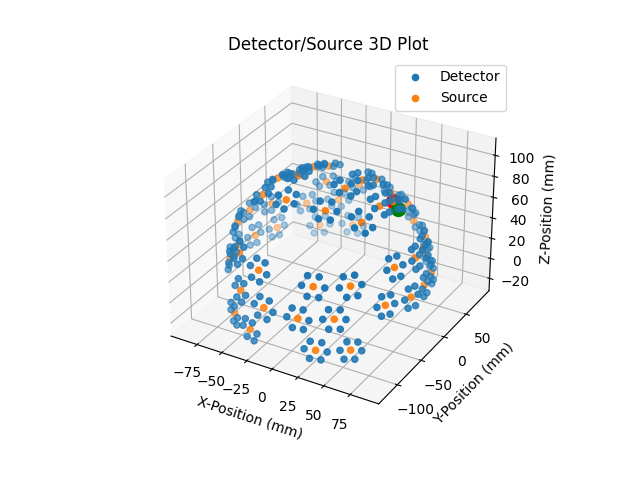

In [4]:
par.flow_session_dict["session_1001"].plot_pos_3d()

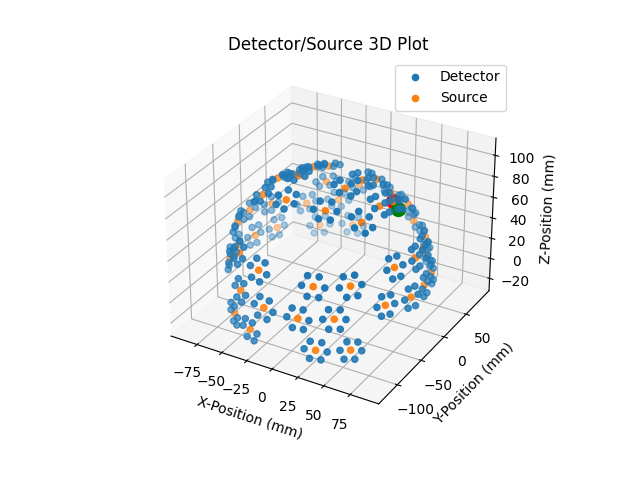

In [5]:
par.flow_session_dict["session_1001"].plot_pos_3d()

In [14]:
# Time offset issue
# Kernel Flow PC - Behavioral Task PC

print(f"Experiment order: {par.par_behav.exp_order}\n")

exp_name = "resting_state"
exp = par.par_behav.get_exp(exp_name)
exp_time_origin_ts = exp.start_ts
exp_time_origin_dt = datetime.datetime.fromtimestamp(exp_time_origin_ts)
print(f"Experiment time origin: {exp_time_origin_dt}")
start_marker_sent_time = float(exp.marker_data["start_marker"]["sent_time"])
print(f"Start marker sent time: {start_marker_sent_time}")
start_marker_sent_time_abs = exp_time_origin_dt + datetime.timedelta(seconds=start_marker_sent_time)
print(f"Start marker sent time (absolute): {start_marker_sent_time_abs}")

# The behavioral start marker sent time (absolute) and 
# kernel start marker receive time (absolute) should be identical.

flow_time_origin = par.flow_session_dict["session_1001"].get_time_origin(offset=False)
print(f"Flow time origin: {flow_time_origin}\n")
session = par.par_behav.get_key_from_value(par.par_behav.session_dict, exp_name)
marker_df = par.flow_session_dict[session].get_marker_df()
print(f"Kernel marker data (original):\n{marker_df}\n")
marker_df_abs = par.create_abs_marker_df(session)
print(f"Kernel marker data (absolute):\n{marker_df_abs}")

row = marker_df_abs.loc[marker_df_abs["Marker"].str.startswith(exp_name)].reset_index()
kernel_start_marker_ts = row.loc[0, "Start timestamp"]
time_offset = kernel_start_marker_ts - (exp_time_origin_ts + start_marker_sent_time)
print(f"\nTime offset: {round(time_offset, 3)}\n")

par_num = 1
par = Participant_Flow(par_num)
time_offset_list = []
print("Time difference:\n------------")
par.time_offset_dict

Experiment order: ['vSAT', 'king_devick', 'audio_narrative', 'resting_state', 'go_no_go', 'video_narrative_sherlock', 'n_back', 'tower_of_london', 'video_narrative_cmiyc']

Experiment time origin: 2022-06-17 14:07:11.993452
Start marker sent time: 14.4406
Start marker sent time (absolute): 2022-06-17 14:07:26.434052
Flow time origin: 2022-06-17 17:40:13

Kernel marker data (original):
    Timestamp    Duration  Value  Experiment
0    18.45619  427.252366    1.0        51.0
1  1110.70192  487.842409    1.0        81.0

Kernel marker data (absolute):
                           Marker  Start timestamp    Duration  End timestamp
0             resting_state_start     1.655489e+09  427.252366   1.655490e+09
1  video_narrative_sherlock_start     1.655490e+09  487.842409   1.655491e+09

Time offset: 13.022

Time difference:
------------


{'resting_state': 12.281041622161865,
 'go_no_go': 12.282827615737915,
 'video_narrative_sherlock': 12.284613609313965,
 'king_devick': 11.980223417282104,
 'vSAT': 11.980556726455688,
 'audio_narrative': 11.982890844345093,
 'n_back': 12.57655382156372,
 'tower_of_london': 12.580034732818604,
 'video_narrative_cmiyc': 12.58246636390686,
 'session_1001': 12.282827615737915,
 'session_1002': 11.981223662694296,
 'session_1003': 12.579684972763062}